*tl*;dr VAE with strength hyperparam for KLD loss to disentangle

paper: https://openreview.net/forum?id=Sy2fzU9gl

1.Libraries and dataset




---



In [11]:
%pylab inline
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

import random

SEED = 1
BATCH_SIZE = 128
cuda = torch.cuda.is_available()
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

dataloader_args = dict()# if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, shuffle=True, batch_size=BATCH_SIZE,num_workers=4, pin_memory=True)
test_loader = dataloader.DataLoader(test, shuffle=False, batch_size=BATCH_SIZE,num_workers=4, pin_memory=True)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'test', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


2. Define Model

In [0]:
Z_DIM = 4
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.Linear(784, 512), nn.ReLU(),
                         nn.Linear(512, 64), nn.ReLU())
        self.fc_mu = nn.Linear(64, Z_DIM)
        self.fc_logvar = nn.Linear(64, Z_DIM)
        self.decoder = nn.Sequential(
                        nn.Linear(Z_DIM, 64), nn.ReLU(),
                        nn.Linear(64, 512), nn.ReLU(),
                         nn.Linear(512, 784), nn.Sigmoid())


    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar): 
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
 
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
      

model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Initial model
PCA explained ratio 0.6563684940338135


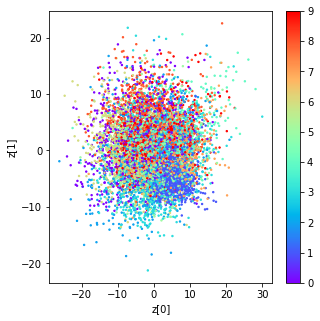

====> Epoch: 1 Average loss: 53.9608
====> Test set loss: 50.2262
PCA explained ratio 0.9790427684783936


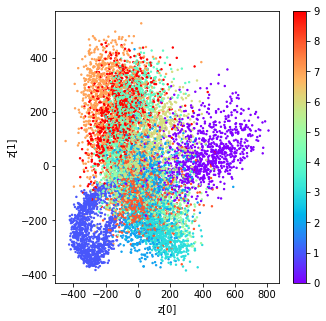

====> Epoch: 2 Average loss: 46.8017
====> Test set loss: 45.6584
PCA explained ratio 0.6967898607254028


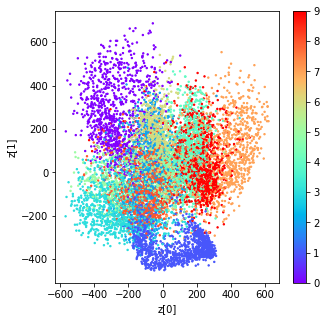

====> Epoch: 3 Average loss: 42.4574
====> Test set loss: 41.8058
PCA explained ratio 0.6242458820343018


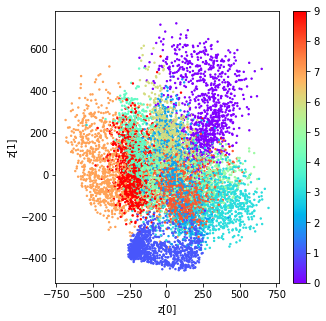

====> Epoch: 4 Average loss: 37.9923
====> Test set loss: 37.2312
PCA explained ratio 0.5389370322227478


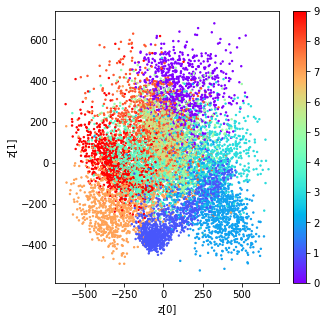

====> Epoch: 5 Average loss: 34.3375
====> Test set loss: 33.7842
PCA explained ratio 0.582682192325592


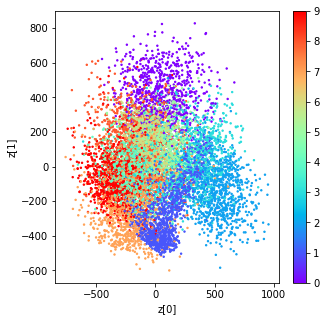

====> Epoch: 6 Average loss: 33.4628
====> Test set loss: 33.0879
PCA explained ratio 0.5628014802932739


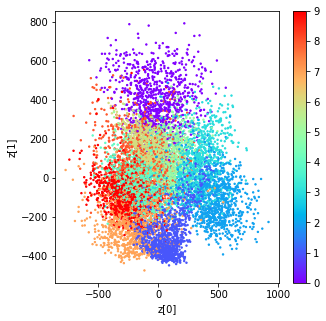

====> Epoch: 7 Average loss: 32.8931
====> Test set loss: 32.6488
PCA explained ratio 0.5765507817268372


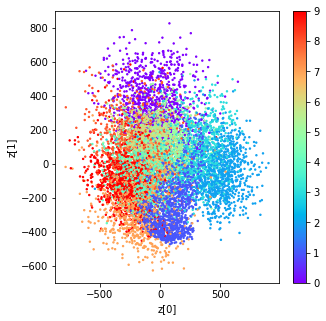

In [13]:
def loss_function(recon_x, x, mu, logvar, beta):
    # recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 1+beta*KLD

LOG_INTERVAL = 50
def train(epoch, beta):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} beta:{:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data), beta),end='')

    print('\r====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch, beta):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.cuda()
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar, beta).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
from sklearn.decomposition import PCA

def plot_z_mean(model, test_loader, model_name="vae_mnist"):
    x_test = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
    y_test = Variable(test_loader.dataset.targets)
    model.eval()

    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "z_mean_plot.png")
    with torch.no_grad():
      recon, z_mean, z_std = model(x_test.cuda())
      z_mean = z_mean.cpu().numpy()
    
    pca = PCA(n_components=2)
    pca.fit(z_mean)
    print('PCA explained ratio {}'.format(sum(pca.explained_variance_ratio_))) 
    z_mean = pca.transform(z_mean)

    plt.figure(figsize=(5, 5))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], 
                c=y_test.numpy(), s=2,
                cmap='rainbow')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()


# train
EPOCHS = 7
print("Initial model")
plot_z_mean(model, test_loader)
beta = 4
min_beta = 1
for epoch in range(1, EPOCHS + 1):
    train(epoch, beta)
    test(epoch, beta)
    plot_z_mean(model, test_loader)
    beta *= 0.7
    if beta < min_beta: 
        beta = min_beta



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


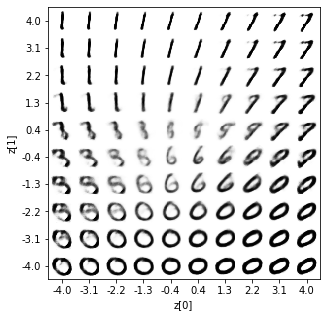

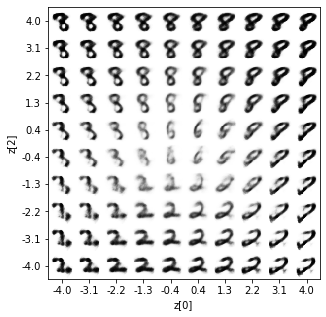

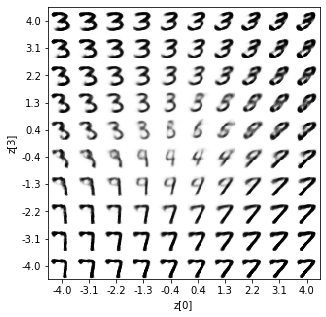

In [14]:
def plot_decoded(model, nouts=10, bound=4, dim1=0, dim2=1, constant=0,
                 model_name="vae_mnist"):
    model.eval()

    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "z_traverse.png")
    digit_size = 28
    figure = np.zeros((digit_size * nouts, digit_size * nouts))
    grid_x = np.linspace(-bound, bound, nouts)
    grid_y = np.linspace(-bound, bound, nouts)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.zeros(Z_DIM).cuda().fill_(constant)
            z_sample[dim1] = xi
            z_sample[dim2] = yi
            x_decoded = model.decode(z_sample)
            with torch.no_grad():
                digit = x_decoded.reshape(digit_size, digit_size).cpu().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = -digit
    plt.figure(figsize=(5, 5))
    start_range = digit_size // 2
    end_range =  nouts * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[{}]".format(dim1))
    plt.ylabel("z[{}]".format(dim2))
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

# plot what traversing on ref dim does to all other dims
ref = 0
for i in range(Z_DIM):
  if i==ref: continue
  plot_decoded(model, dim1=ref, dim2=i)